In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


In [2]:
cd_data = 'data/'
file = 'flight_delays.csv'
df = pd.read_csv(cd_data+file)
df.head()

,UniqueCarrier,ArrDelay,DestWac,LateAircraftDelay,TaxiOut,ArrTime,DepDelay,Dest,TaxiIn,WeatherDelay,OriginWac,DepTime,Distance,AirTime,SecurityDelay,Diverted,Origin,CarrierDelay,NASDelay,FlightDate
0,AA,-14.0,81,NaN,17.0,1842.0,-3.0,PHX,5.0,0.0,36,1616.0,1773.0,244.0,0.0,0.0,CLT,0.0,0.0,2017-01-17
1,AA,-35.0,81,NaN,13.0,1821.0,-5.0,PHX,6.0,0.0,36,1614.0,1773.0,228.0,0.0,0.0,CLT,0.0,0.0,2017-01-18
2,AA,-30.0,81,NaN,17.0,1826.0,-8.0,PHX,2.0,0.0,36,1611.0,1773.0,236.0,0.0,0.0,CLT,0.0,0.0,2017-01-19
3,AA,33.0,81,0.0,18.0,1929.0,37.0,PHX,3.0,0.0,36,1656.0,1773.0,252.0,0.0,0.0,CLT,33.0,0.0,2017-01-20
4,AA,2.0,81,NaN,17.0,1858.0,13.0,PHX,4.0,0.0,36,1632.0,1773.0,245.0,0.0,0.0,CLT,0.0,0.0,2017-01-21


In [3]:
print('\n___________Shape___________\n', df.shape, '\n___________Info___________\n')
print( df.info())
print('\n___________Statistics___________\n', df.describe())



___________Shape___________
 (450017, 20) 
___________Info___________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   UniqueCarrier      450017 non-null  object 
 1   ArrDelay           450017 non-null  float64
 2   DestWac            450017 non-null  int64  
 3   LateAircraftDelay  97699 non-null   float64
 4   TaxiOut            450017 non-null  float64
 5   ArrTime            450017 non-null  float64
 6   DepDelay           450017 non-null  float64
 7   Dest               450017 non-null  object 
 8   TaxiIn             450017 non-null  float64
 9   WeatherDelay       450017 non-null  float64
 10  OriginWac          450017 non-null  int64  
 11  DepTime            450017 non-null  float64
 12  Distance           450017 non-null  float64
 13  AirTime            439645 non-null  float64
 14  SecurityDelay      450017 no

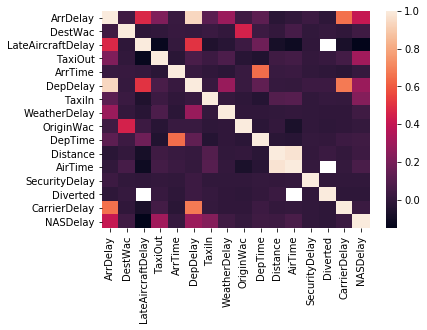

In [4]:
df_numbers_only = df.drop('UniqueCarrier', axis=1)
sns.heatmap(df_numbers_only.corr())
plt.savefig('figures/Heatmap.png')



## Heatmap Observations
 - Wac shows a correlation, however this is an ID according to Column_info.txt and can be igonored.
 - There is a correlation between departure time and arrival time that is nearly common sense, however further investigation is certainly warrented.
 - The distance and air time columns have a strong correlation. This is not all that surprising, however this can be investigated with other parameters.
 - Departure delay and late aircraft delay is correlated. Likely an easy prediciton once the aircraft delay is accounced for but we are looking to predict the initial delay.
 - ~~A diverted aircraft lines up with late aicraft delays, arrival delays, carrier delays, and NAS delays. According to the data set's information the NAS is "National Air System Delay, in Minutes".~~
    - After resampling late aircraft delays and airtime, these correlations did not appear in the heat map.
 - The departure and late aircraft correlation is suprisingly weak.
 What we are really interested in here is the delays and other causes that can contribute to these recorded delays.



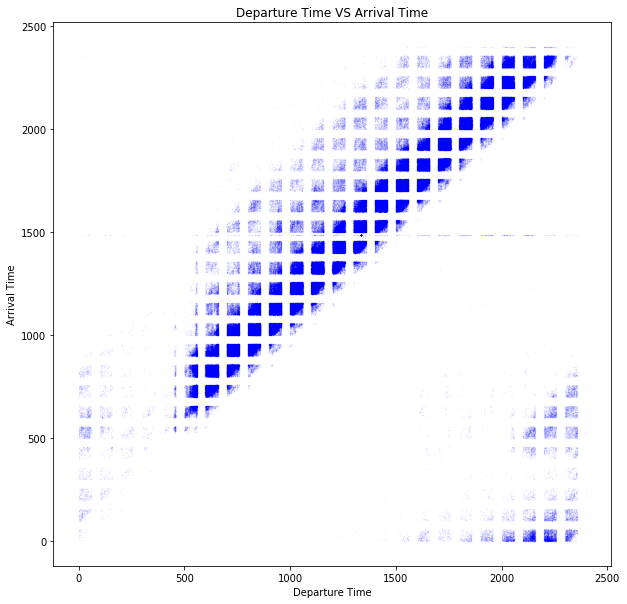

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(df['DepTime'], df['ArrTime'], alpha=0.1, color='blue', s=0.03)
plt.title('Departure Time VS Arrival Time')
plt.xlabel('Departure Time')
plt.ylabel('Arrival Time')
plt.savefig('figures/DepTime_VS_ArrTime.png')

As expected there is a very strong correlation with departure time and arrival time. This could be clearly predicted with a linear regression model and certainly could be a piece in later analysis.

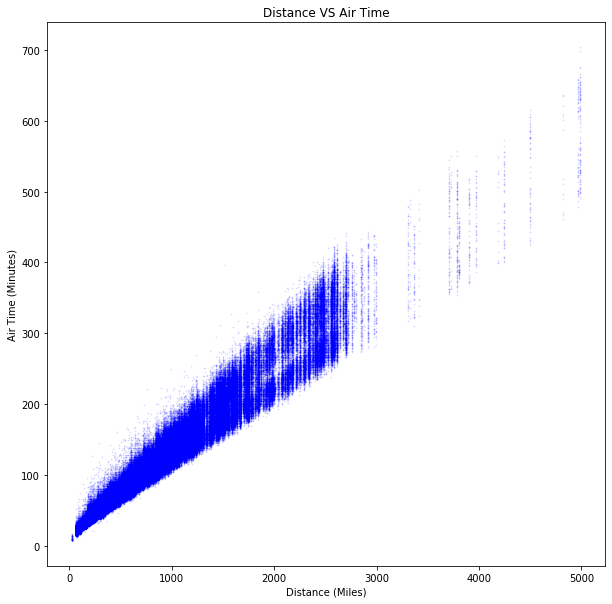

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(df['Distance'], df['AirTime'], alpha=0.1, color='blue', s=0.8)
plt.title('Distance VS Air Time')
plt.xlabel('Distance (Miles)')
plt.ylabel('Air Time (Minutes)')
plt.savefig('figures/Distance_VS_AirTime.png')

The linear regression is even more pronounced here showing a narrow range of posibilities.

~~There seems to also be a straight line hovering above 100 minutes of airtime with a range of distance. This could mean that there is an issue in the reported data. Likely where I filled Nan values with Means.~~ 
*(This was due to Nans being replaced by means. Since then they have been resampled at the line has been removed.)* 



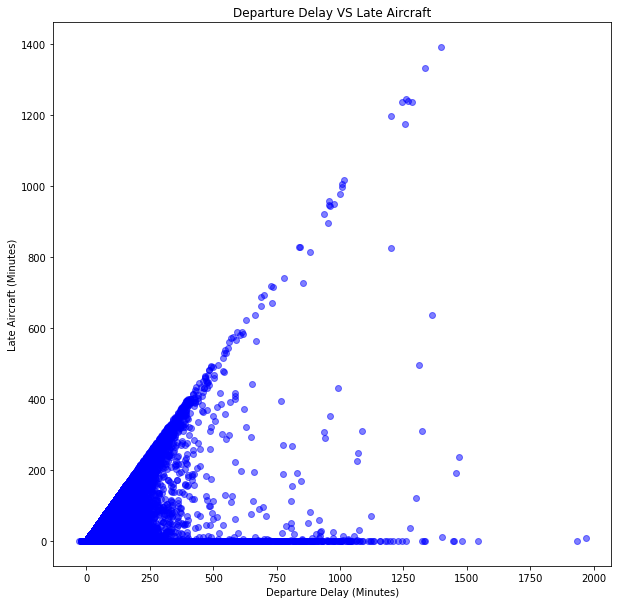

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(df['DepDelay'], df['LateAircraftDelay'], alpha=0.5, color='blue', )
plt.title('Departure Delay VS Late Aircraft')
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Late Aircraft (Minutes)')
plt.savefig('figures/DepDelay_VS_LateAircraft.png')


Again there is a sharp linear regression with most data points sitting below 200 minutes.
Several outliers sit well beyond that mark but are still within the regression.
Many data points are showing a late aircraft delay of 0. Which is remarkable even after resampling missing data.
This suggests that departure delays are not always a causation of a late aircraft.

In [8]:
df.columns
plt.figure(figsize=(10,10))
df['Diverted'].value_counts()

0.0    448531
1.0      1486
Name: Diverted, dtype: int64

<Figure size 720x720 with 0 Axes>

It appears that the diverted correlations are not interesting because the diverted column is a boolean value.
This may be more useful later on, but for now it does not help.


## Scatterplot Observations
Now that I have had some observations on the measurements on flight delays, I can start attacking the date time objects and looking for when one flight delay that will cause another.
My hypothosis is: " The amount of flights delayed at the origin will affect the amount of flights delayed at the destination."
In order to test my hypthosis, I will need to narrow down on one airport and find some flight delays. Then I can follow those flights and look for these chain reaction delays causing other flights to be delayed.

In [9]:
df.columns
# A single delay paramter.
df_delays_sum = df['CarrierDelay'] + df['ArrDelay'] + df['NASDelay'] + df['DepDelay'] + df['SecurityDelay'] + df['LateAircraftDelay']

df['DelaySum'] = df_delays_sum
df['DelaySum'] = df['DelaySum'].fillna(0)
#Filling the Nan delays with zero as to not throw off the average.

flight_info = ['Origin', 'Dest', 'FlightDate', 'DelaySum']
print(df[df['DelaySum'] ==  df['DelaySum'].max()][flight_info])
print(df['DelaySum'].max()/60/24)

       Origin Dest  FlightDate  DelaySum
130636    BWI  DFW  2017-01-11    5804.0
4.030555555555556


### Where to look
> The flight that experinced the longest delay in 2017 was from Baltimore/Washington International Airport and going to Dallas/Fort Worth International Airport.
The Delay was just over 4 days and the actual flight date took place on January 11th.
It just so happens that on January 7th there was a severe winter storm orginating 78 Nautical Miles South West of Baltimore at the Philadelphia International Airport that caused flight delays that left passengers without an estimate.
The article on the storm in Philadelphia is sited here: https://philly.metro.us/weather-causes-delays-cancellations-at-philly-airport/

I believe we can expect this to be an outlier. Under these extreme conditions, the recovery for the flight delay caused by this aircraft was doubtfully the entire 4 days. What I am looking for is to predict most of the flight delays, not just the extreme weather delays.
So from here I will move on to grouping the data by desination and finding the maximum average delay by flight destination.

In [10]:
df['DelaySum'].describe()
df_group = df.groupby('Dest')
df_group[flight_info].head()

destinations = list(df['Dest'].unique())
groups_mean = {}
for destination in destinations:
    groups_mean[destination] = [df[df['Dest'] == destination]['DelaySum'].mean()]
df_group = pd.DataFrame(groups_mean).max()
df_group[df_group == df_group.max()]
# ELM = Elmira Corning Regional Airport - New York
# DTW = Detroit Metropolitan Airport

df[df['Dest'] == 'ELM'][flight_info]
# Interesting. The higest average of delays contains flight from Elmira Corning Regional Airport to Detroit Metropolitan Airport.
# Lets check out DTW to see if my hypothosis holds true.
print("\n________The highest average delay time________\n", df[df['Dest'] == 'DTW']['DelaySum'].mean())
print("\n________Flight info on in Januwary 2017 at Elmira Corning Regional Airport________\n", df[df['Dest'] == 'DTW'][flight_info])
# Number of flight delays for any reason for flights going to Detroit Metropolitan Airport
print("\n________The count of total flight delays in January at Elmira Corning Regional Airport________\n", df[(df['Dest'] == 'ELM') & (df['DelaySum'] > 0)]['DelaySum'].count())
print("\n________Delay Ratio_______\n", df[(df['Dest'] == 'ELM') & (df['DelaySum'] > 0)]['DelaySum'].count()/df[df['Dest'] == 'ELM']['DelaySum'].count())



________The highest average delay time________
 42.85836423568191

________Flight info on in Januwary 2017 at Elmira Corning Regional Airport________
        Origin Dest  FlightDate  DelaySum
10062     MIA  DTW  2017-01-01       0.0
10063     MIA  DTW  2017-01-02      99.0
10064     MIA  DTW  2017-01-03       0.0
10065     MIA  DTW  2017-01-04       0.0
10066     MIA  DTW  2017-01-05      62.0
...       ...  ...         ...       ...
449617    BNA  DTW  2017-01-24       0.0
449618    BNA  DTW  2017-01-24       0.0
449844    BWI  DTW  2017-01-24       0.0
449845    BWI  DTW  2017-01-24       0.0
449846    BWI  DTW  2017-01-24       0.0

[9708 rows x 4 columns]

________The count of total flight delays in January at Elmira Corning Regional Airport________
 7

________Delay Ratio_______
 0.5384615384615384


I supsect the reason that I found Elmira Corning Regional Airport is because it does not have many data points at all! Infact there are only 7 delays in total and almost 54% of the flights from this airport were delayed!
The central limit theorem would suggest that I have found this smaller airport by chance. The one long flight delay is wildely skewing the data.


In [11]:
destinations = list(df['Dest'].unique())
groups_count = {}
for destination in destinations:
    groups_count[destination] = df[(df['Dest'] == destination) & (df['DelaySum'] > 0)].count()

df_group = pd.DataFrame(groups_count).max()
df_group[df_group == df_group.max()]

LAX    6064
dtype: int64

This shows that the Los Angelos International Airport was the biggest offender of incoming flight delays.
This may be prosecuter's fallacy because LAX happens to also be one of the busiest airports.
Either way it makes a good place to start.

From here the experiement will work as follows:
- Treat a flight delay like it has a half life and count the number of relational delays going out of LAX to the next similar airport.
- Then we can expect that there is a chance this amount of delays will cause more delays at the next airport.


In [12]:

destinations = list(df['Origin'].unique())
groups_count = {}
for destination in destinations:
    groups_count[destination] = df[(df['Origin'] == destination) & (df['DelaySum'] > 0)].count()

df_group = pd.DataFrame(groups_count).max()
df_group[df_group == df_group.max()]

ATL    5974
dtype: int64

This shows that Hartsfield-Jackson Atlanta International Airport is the biggest offender in January 2017 of out going flight delays. 

Next we can develop a way to measure flight delays by origin and date.

In [13]:
dates = list(df['FlightDate'].unique())
def calculate_origin_ratios(origin, df=df, dates=dates, flight_info=flight_info):
    """
    df = The default DataFrame
    dates = taken as a list of datetime objects
    origin = specifies which Origin to choose in the origin column.
    flight_info = ['Origin', 'Dest', 'FlightDate', 'DelaySum']
        The purpose of this list was to make the dataframe smaller
        and easier to work with for specific operations
    _______________________________________________________________
    The purpose of this function is to take flight data and return a
    flight delay ratio by origin.
    """
    result = {
    'Origin':[],
    'FlightDate':[],
    'DelayRatio':[],
    }
    for date in dates:

        flights_by_date = df[(df['FlightDate'] == date) & (df['Origin'] == origin)][flight_info]
        num_delays = flights_by_date[flights_by_date['DelaySum'] > 0]['DelaySum'].count()
        num_flights = flights_by_date['DelaySum'].count()

        try:
            delay_ratio = num_delays/num_flights
        except ZeroDivisionError:
            # If there are no flights at an airport. There is a possibility to divide by 0
            delay_ratio = 0

        result['Origin'].append(origin)
        result['FlightDate'].append(date)
        result['DelayRatio'].append(delay_ratio)
    return(pd.DataFrame(result))

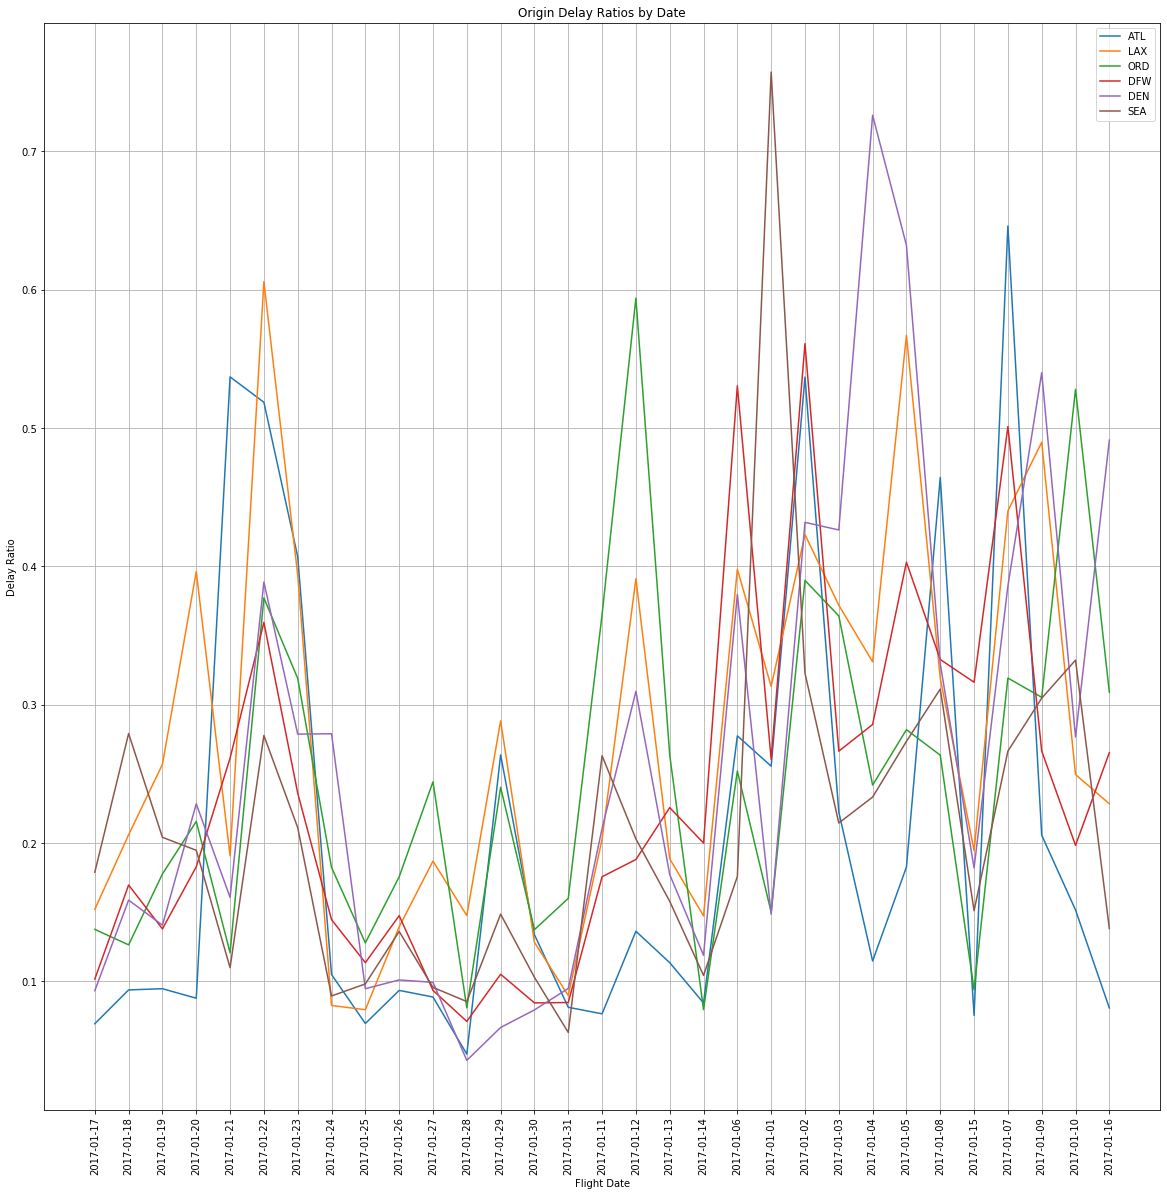

In [14]:

#TOP 6 airports Seattle is actually 7th on the list, however I wanted to even out my plot geographically.
origins = ['ATL', 'LAX', 'ORD', 'DFW', 'DEN', 'SEA']
plt.figure(figsize=(20,20))
plt.grid()
for origin in origins:
    origin_ratio = calculate_origin_ratios(origin)
    plt.plot(origin_ratio['FlightDate'], origin_ratio['DelayRatio'], label=origin)
plt.xlabel('Flight Date')
plt.xticks(rotation=90)
plt.ylabel('Delay Ratio')
plt.title('Origin Delay Ratios by Date')
plt.legend()
plt.savefig('figures/DelayRatios.png')

### Testing

If we go back to the flight info filter and check LAX to ATL, we can reference the plot and attempt to find delays from ATL to other airports that may have orginated with the LAX delay.

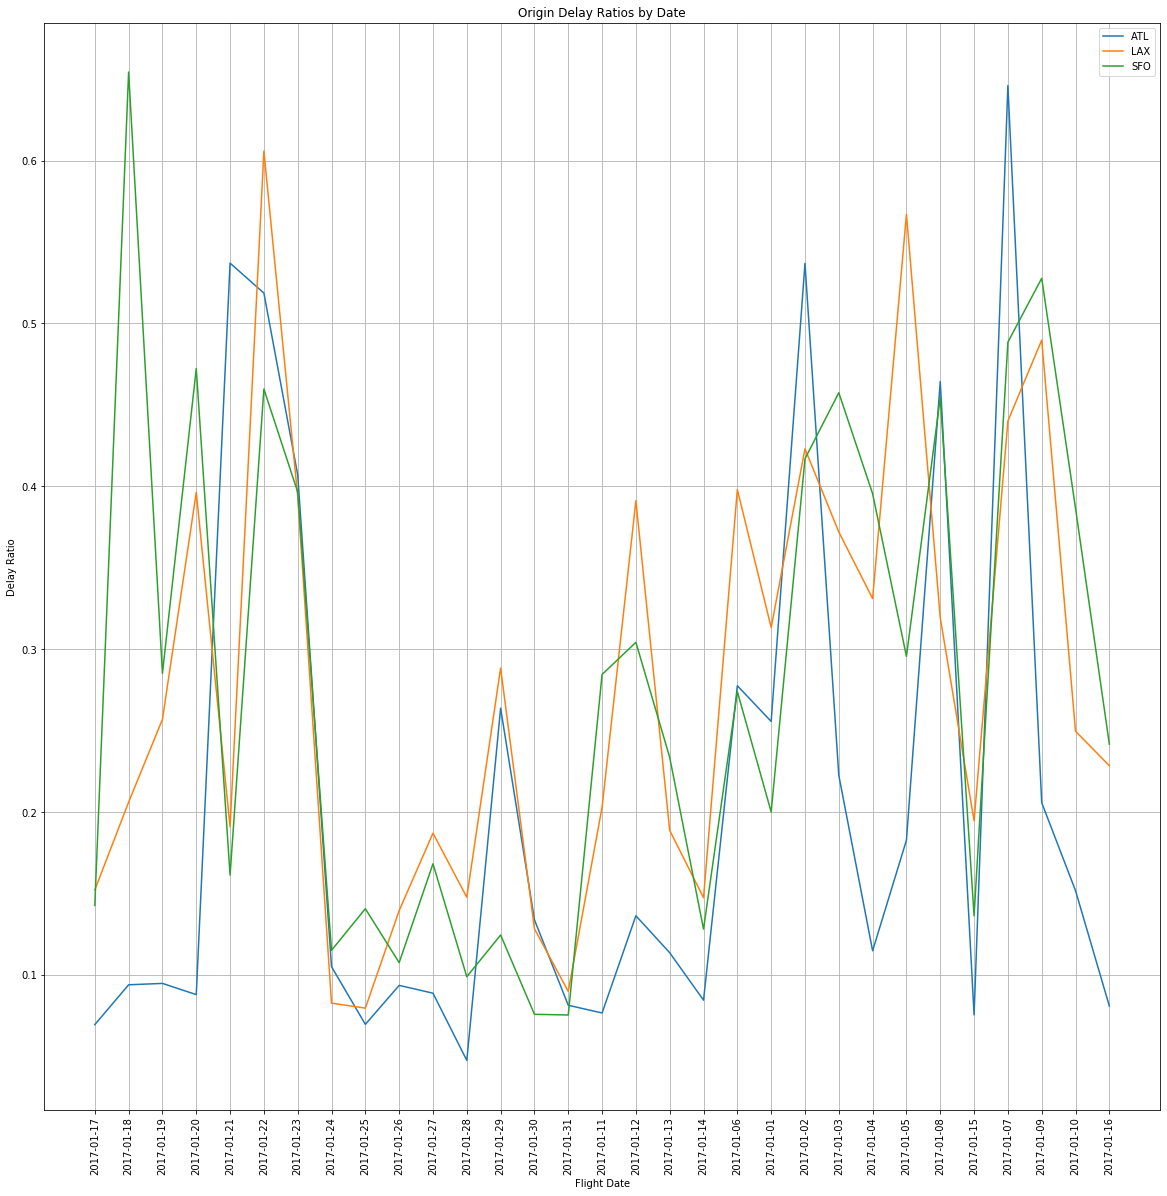

In [15]:
lax_atl = df[(df['Origin'] == 'LAX') | (df['Origin'] == 'ATL')][flight_info]
lax_atl['Dest'].value_counts()
# SFO appears to have the most destinations of flights from LAX and ATL. We should expect the delays to correlate.
dates = list(df['FlightDate'].unique())
#TOP 6 airports Seattle is actually 7th on the list, however I wanted to even out my plot geographically.
origins = ['ATL', 'LAX', 'SFO']
plt.figure(figsize=(20,20))
plt.grid()
for origin in origins:
    origin_ratio = calculate_origin_ratios(origin)
    plt.plot(origin_ratio['FlightDate'], origin_ratio['DelayRatio'], label=origin)
plt.xlabel('Flight Date')
plt.xticks(rotation=90)
plt.ylabel('Delay Ratio')
plt.title('Origin Delay Ratios by Date')
plt.legend()
plt.savefig('figures/DelayRatios_ATL_LAX_SFO.png')


## observations
There is certainly a chance that the delay ratios for SFO peaked after LAX and ATL later in the month.
Earlier in the month the opposite occurs. However this could be due to delayed flights in SFO going to LAX and ATL.
More testing is required to be sure.

From here we will need to split the data into regions and find the mean delay ratios per region. First I will need to define regions and airports within those regions. I will use the this list of [Top 100 Airports](http://www.fi-aeroweb.com/Top-100-US-Airports.html). Then we can divide the airports into regions according to the [Census Region Division of the US](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)

In [16]:
pacific = ['LAX', 'SFO', 'SEA', 'SAN', 'HNL', 'PDX', 'OAK', 'SJC', 'SMF', 'SNA', 'OGG', 'ANC', 'BUR', 'ONT', 'LGB', 'KOA', 'GEG', 'LIH', 'PSP', ]
mountain = ['DEN', 'LAS', 'PHX', 'SLC', 'ABQ', 'RNO', 'BOI', 'TUS', 'COS']
west_north_central = ['DFW', 'MSP', 'STL', 'MCI', 'NE', 'DSM', 'ICT']
west_south_central = ['IAH', 'DAL', 'AUS', 'HOU', 'MSY', 'SAT', 'OKC', 'ELP', 'TUL', 'LIT', ]
east_north_cenral = ['ORD','DTW','MDW', 'CLE', 'IND', 'CVG', 'CMH', 'MKE', 'GRR', 'MSN', 'DAY']
east_south_central = ['BNA', 'MEM', 'SDF', 'BHM', 'TYS']
middle_atlantic = ['JFK', 'EWR', 'LGA', 'PHL', 'PIT', 'BUF', 'BHM', 'ROC', 'SYR']
south_atlantic = ['ATL', 'CLT', 'MCO', 'MIA', 'FLL', 'BWI', 'DCA', 'IAD', 'TPA', 'RDU', 'RSW', 'PBI', 'JAX', 'CHS', 'RIC', 'ORF', 'SFB', 'SAV', 'MYR', 'GSP', 'PIE', 'GSO', 'PNS']
new_england = ['BOS', 'BDL', 'PVD', 'MHT', 'PWM']

In [17]:
df.columns

Index(['UniqueCarrier', 'ArrDelay', 'DestWac', 'LateAircraftDelay', 'TaxiOut',
       'ArrTime', 'DepDelay', 'Dest', 'TaxiIn', 'WeatherDelay', 'OriginWac',
       'DepTime', 'Distance', 'AirTime', 'SecurityDelay', 'Diverted', 'Origin',
       'CarrierDelay', 'NASDelay', 'FlightDate', 'DelaySum'],
      dtype='object')

In [44]:
pacific_df = df[df['Origin'].isin(pacific)]

def calculate_region_ratios(regions):
    ratios = []
    for region in regions:
        region_ratio = calculate_origin_ratios(region)
        ratios.append(region_ratio)
    return pd.concat(ratios)
        

        

In [45]:
pacific_region_delays = calculate_region_ratios(pacific)
pacific_region_delays = pacific_region_delays.drop('Origin')



In [61]:
def calculate_region_means(region, df=df):
    flight_dates = region['FlightDate'].unique()
    ratio_means = {'FlightDate': [], 'DelayRatio': []}
    for flight_date in flight_dates:
        ratio_means['FlightDate'].append(flight_date)
        ratio_means['DelayRatio'].append(np.mean(region[region['FlightDate'] == flight_date]['DelayRatio']))
    return pd.DataFrame(ratio_means)
    

In [63]:
pacific_DelayRatio = calculate_region_means(pacific_region_delays)

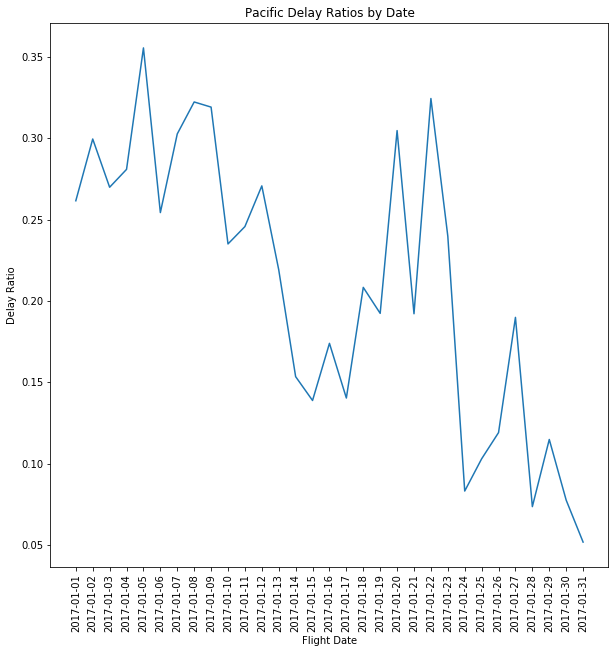

In [68]:
plt.figure(figsize=(10,10))
plt.plot(p_region['FlightDate'], p_region['DelayRatio'])
plt.xlabel('Flight Date')
plt.xticks(rotation=90)
plt.ylabel('Delay Ratio')
plt.title('Pacific Delay Ratios by Date')
plt.savefig('figures/DelayRatios_Pacific.png')